In [3]:
#

In [4]:
# https://www.kaggle.com/c/santander-customer-satisfaction/overview
# https://www.kaggle.com/kobakhit/0-84-score-with-36-features-only

In [10]:
#

In [11]:
import pandas as pd
import numpy as np

In [6]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt

In [7]:
import xgboost as xgb

In [8]:
#

In [12]:
train = pd.read_csv("./santander_train.csv")

In [13]:
test = pd.read_csv("./santander_test.csv")

In [14]:
#

In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [16]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75818 entries, 0 to 75817
Columns: 370 entries, ID to var38
dtypes: float64(110), int64(260)
memory usage: 214.0 MB


In [11]:
#

In [17]:
remove = []
for col in train.columns:
    if train[col].std() == 0:
        remove.append(col)

In [18]:
train.drop(remove, axis=1, inplace=True)
test.drop(remove, axis=1, inplace=True)

In [19]:
remove = []
cols = train.columns
for i in range(len(cols)-1):
    v = train[cols[i]].values
    for j in range(i+1,len(cols)):
        if np.array_equal(v,train[cols[j]].values):
            remove.append(cols[j])

In [20]:
train.drop(remove, axis=1, inplace=True)
test.drop(remove, axis=1, inplace=True)

In [21]:
test_id = test.ID
test = test.drop(["ID"],axis=1)

In [22]:
X = train.drop(["TARGET","ID"],axis=1)
y = train.TARGET.values


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1729)

In [24]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(60816, 306) (15204, 306) (60816,) (15204,)


In [25]:
print(test.shape)

(75818, 306)


In [26]:
clf = ExtraTreesClassifier(random_state=1729)

In [27]:
selector = clf.fit(X_train, y_train)

In [28]:
feat_imp = pd.Series(clf.feature_importances_, index = X_train.columns.values).sort_values(ascending=False)

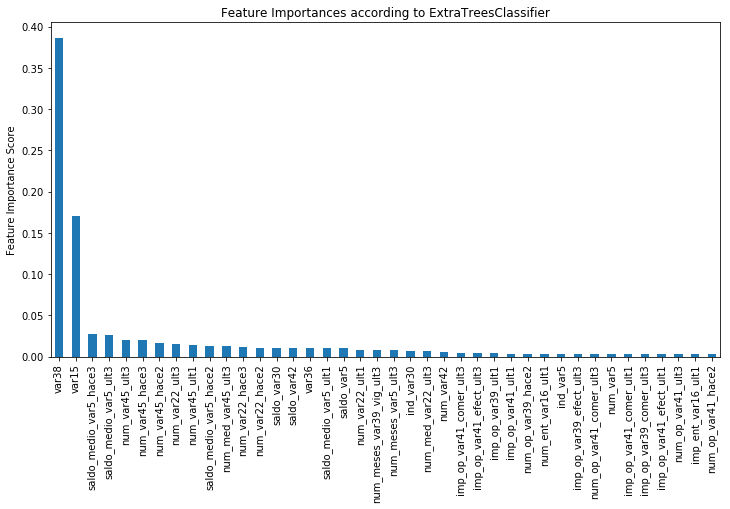

In [29]:
feat_imp[:40].plot(kind='bar', title='Feature Importances according to ExtraTreesClassifier', figsize=(12, 8))
plt.ylabel('Feature Importance Score')
plt.subplots_adjust(bottom=0.3)
plt.savefig('1.png')
plt.show()

In [30]:
fs = SelectFromModel(selector, prefit=True)

In [31]:
X_train = fs.transform(X_train)
X_test = fs.transform(X_test)

/data/anaconda3/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


In [32]:
test = fs.transform(test)

/data/anaconda3/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


In [33]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(60816, 36) (15204, 36) (60816,) (15204,)


In [34]:
print(test.shape)

(75818, 36)


In [35]:
#

In [36]:
m2_xgb = xgb.XGBClassifier(n_estimators=110, nthread=-1, max_depth = 4, seed=1729)

In [37]:
m2_xgb.fit(X_train, y_train, eval_metric="auc", verbose = False, eval_set=[(X_test, y_test)])

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=110, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=1729, silent=True, subsample=1)

In [38]:
#

In [39]:
X_predict = m2_xgb.predict_proba(X_test)[:,1]

In [40]:
roc_auc = roc_auc_score(y_test, X_predict)

In [41]:
print(roc_auc)

0.8316521354856642


In [42]:
#

In [43]:
probs = m2_xgb.predict_proba(test)

In [44]:
submission = pd.DataFrame({"ID":test_id, "TARGET": probs[:,1]})

In [45]:
# submission.to_csv("submission.csv", index=False)